# GameNetAPI Network Performance Metrics

This notebook visualizes network performance metrics from the CS3103 Assignment 4 test results.

**Metrics analyzed:**
- Latency (one-way delay)
- Jitter (latency variation)
- Throughput (bytes/sec)
- Round-Trip Time (RTT)
- Packet Delivery Ratio (PDR)

**Data sources:**
- `results/metrics-*.json` - Sender-side metrics
- `results/Receiver-*.json` - Receiver-side metrics

## 1. Import Required Libraries

In [146]:
import json
import glob
import os
import matplotlib.pyplot as plt
import pandas as pd

# Configure matplotlib for better plots
plt.style.use('seaborn-v0_8-darkgrid')
%matplotlib inline

## 2. Configure Paths and Create Output Directory

In [147]:
RESULTS_DIR = "results"
FIGURES_DIR = "figures"

# Create output directory for figures
os.makedirs(FIGURES_DIR, exist_ok=True)

print(f"✓ Results directory: {RESULTS_DIR}")
print(f"✓ Output directory: {FIGURES_DIR}")

✓ Results directory: results
✓ Output directory: figures


## 3. Load and Parse Sender Metrics

Load sender-side metrics from `Sender-*.json` files including RTT, throughput, and channel type.

In [148]:
sender_files = sorted(glob.glob(os.path.join(RESULTS_DIR, "Sender-*.json")))
sender_rows = []

for f in sender_files:
    try:
        data = json.load(open(f))
        label = data.get("label", os.path.basename(f).replace("Sender-", "").replace(".json", ""))
        overall = data["overall"]
        reliable = data["reliable"]
        unreliable = data["unreliable"]
        
        # Determine channel type from filename
        channel = "Unreliable" if "unreliable" in label.lower() else "Reliable"

        sender_rows.append({
            "label": label,
            "channel": channel,
            "duration_s": data["duration"],
            "packets_sent": overall["packets_sent"],
            "throughput_bps_send": overall["send_throughput_bps"],
            "rtt_ms": reliable["avg_rtt_ms"]
        })
    except Exception as e:
        print(f"⚠️  Skipping sender file {f}: {e}")

df_sender = pd.DataFrame(sender_rows)

# Sort in custom order: Small, Large, Rapid, Unreliable
def sort_key(label):
    label_lower = label.lower()
    if "small" in label_lower:
        return 0
    elif "large" in label_lower:
        return 1
    elif "rapid" in label_lower:
        return 2
    elif "unreliable" in label_lower:
        return 3
    else:
        return 4

df_sender["sort_order"] = df_sender["label"].apply(sort_key)
df_sender = df_sender.sort_values("sort_order").drop("sort_order", axis=1).reset_index(drop=True)

print(f"✓ Loaded {len(df_sender)} sender metric files")
df_sender.head()


✓ Loaded 4 sender metric files


,label,channel,duration_s,packets_sent,throughput_bps_send,rtt_ms
0,Sender-Small reliable batch,Reliable,2.011085,10,45.249200,100.620127
1,Sender-Large reliable batch,Reliable,2.347906,50,209.122502,119.976106
2,Sender-Rapid reliable messages,Reliable,6.805621,200,307.392977,128.430585
3,Sender-Unreliable messages,Unreliable,21.216710,200,98.601529,0.000000


## 4. Load and Parse Receiver Metrics

Load receiver-side metrics from `Receiver-*.json` files including latency, jitter, throughput, and packet delivery ratio.

In [149]:
receiver_files = sorted(glob.glob(os.path.join(RESULTS_DIR, "Receiver-*.json")))
receiver_rows = []

for f in receiver_files:
    try:
        data = json.load(open(f))
        label = data.get("label", os.path.basename(f).replace("Receiver-", "").replace(".json", ""))
        overall = data["overall"]
        reliable = data["reliable"]
        unreliable = data["unreliable"]
        
        # Determine channel type from filename
        channel = "Unreliable" if "unreliable" in label.lower() else "Reliable"
        
        receiver_rows.append({
            "label": label,
            "channel": channel,
            "duration_s": data["duration"],
            "packets_received": overall["packets_received"],
            "latency_ms": reliable["avg_latency_ms"],
            "jitter_ms": reliable["jitter_ms"],
            "throughput_bps_recv": overall["recv_throughput_bps"],
            "pdr_pct": reliable["delivery_ratio_pct"] if channel == "Reliable" else unreliable["delivery_ratio_pct"]
        })
    except Exception as e:
        print(f"⚠️  Skipping receiver file {f}: {e}")

df_recv = pd.DataFrame(receiver_rows)

# Sort in custom order: Small, Large, Rapid, Unreliable
def sort_key(label):
    label_lower = label.lower()
    if "small" in label_lower:
        return 0
    elif "large" in label_lower:
        return 1
    elif "rapid" in label_lower:
        return 2
    elif "unreliable" in label_lower:
        return 3
    else:
        return 4

df_recv["sort_order"] = df_recv["label"].apply(sort_key)
df_recv = df_recv.sort_values("sort_order").drop("sort_order", axis=1).reset_index(drop=True)

print(f"✓ Loaded {len(df_recv)} receiver metric files")
df_recv.head()


✓ Loaded 4 receiver metric files


,label,channel,duration_s,packets_received,latency_ms,jitter_ms,throughput_bps_recv,pdr_pct
0,Receiver-Small reliable batch,Reliable,9.057347,10,55.035377,2.381879,10.047093,100.0
1,Receiver-Large reliable batch,Reliable,8.512606,50,67.487106,32.665733,57.679163,100.0
2,Receiver-Rapid reliable messages,Reliable,13.020561,200,75.924695,40.423091,160.668961,100.0
3,Receiver-Unreliable messages,Unreliable,27.549914,199,0.000000,0.000000,75.535625,99.5


## 5. Display Combined Summary

Combine sender and receiver metrics into a single summary table showing key performance indicators.

In [150]:
if not df_sender.empty and not df_recv.empty:
    # Calculate averages across all tests
    summary = {
        "Latency (ms)": df_recv["latency_ms"].mean(),
        "Jitter (ms)": df_recv["jitter_ms"].mean(),
        "Send Throughput (bytes/sec)": df_sender["throughput_bps_send"].mean(),
        "Recv Throughput (bytes/sec)": df_recv["throughput_bps_recv"].mean(),
        "Packet Delivery Ratio (%)": df_recv["pdr_pct"].mean(),
        "Average RTT (ms)": df_sender[df_sender["rtt_ms"] > 0]["rtt_ms"].mean()
    }
    
    print("=" * 60)
    print("COMBINED PERFORMANCE SUMMARY")
    print("=" * 60)
    for k, v in summary.items():
        print(f"{k:35}: {v:10.2f}")
    print("=" * 60)
else:
    print("⚠️  Insufficient data for summary")

COMBINED PERFORMANCE SUMMARY
Latency (ms)                       :      49.61
Jitter (ms)                        :      18.87
Send Throughput (bytes/sec)        :     165.09
Recv Throughput (bytes/sec)        :      75.98
Packet Delivery Ratio (%)          :      99.88
Average RTT (ms)                   :     116.34


## 6. Plot: Average RTT per Test

Compare round-trip times across different test scenarios, showing the difference between reliable and unreliable channels.

✓ Saved: figures/rtt_ms.png


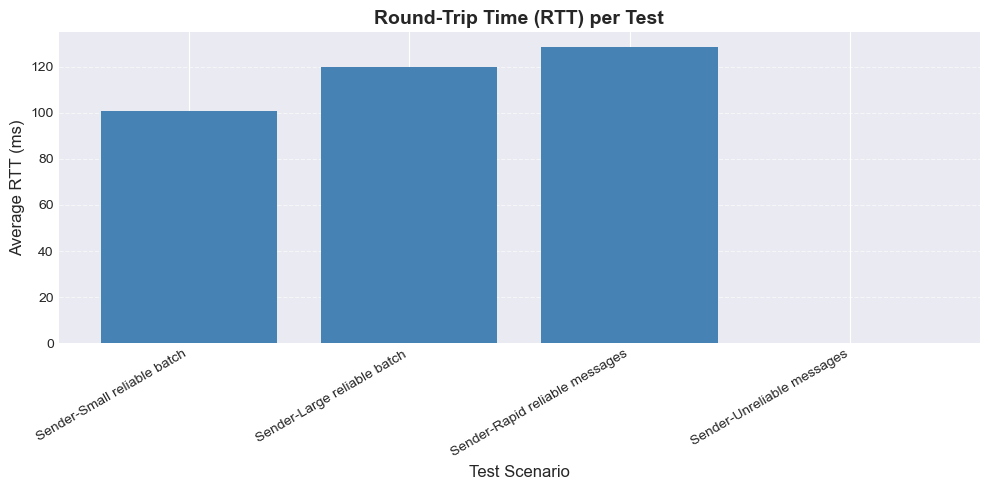

In [151]:
if not df_sender.empty:
    plt.figure(figsize=(10, 5))
    colors = df_sender["channel"].map({"Reliable": "steelblue", "Unreliable": "orange"})
    plt.bar(df_sender["label"], df_sender["rtt_ms"], color=colors)
    plt.ylabel("Average RTT (ms)", fontsize=12)
    plt.xlabel("Test Scenario", fontsize=12)
    plt.title("Round-Trip Time (RTT) per Test", fontsize=14, fontweight='bold')
    plt.xticks(rotation=30, ha="right")
    plt.grid(axis="y", linestyle="--", alpha=0.6)
    plt.tight_layout()
    
    out = os.path.join(FIGURES_DIR, "rtt_ms.png")
    plt.savefig(out, dpi=300, bbox_inches='tight')
    print(f"✓ Saved: {out}")
    plt.show()
else:
    print("⚠️  No sender data available for RTT plot")

## 7. Plot: Sender Throughput per Test

Visualize the sending throughput for each test scenario.

✓ Saved: figures/throughput_bps_send.png


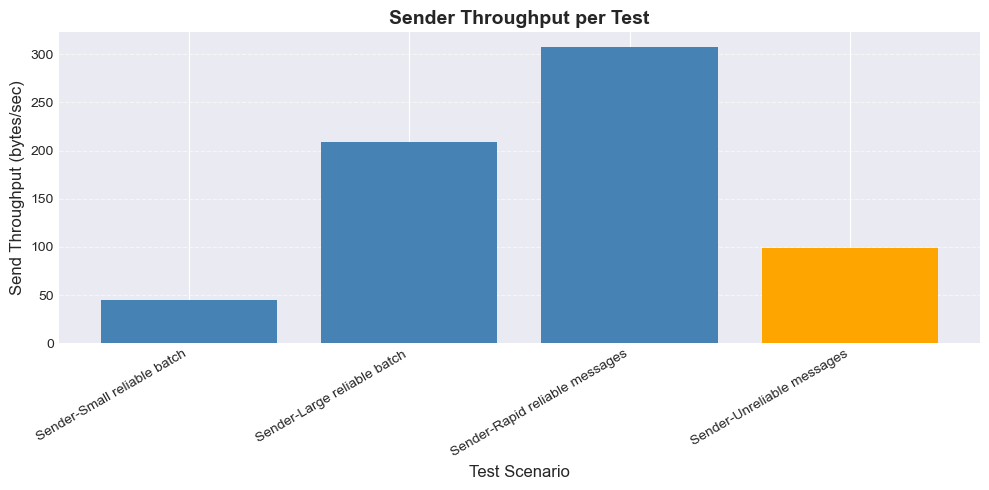

In [152]:
if not df_sender.empty:
    plt.figure(figsize=(10, 5))
    colors = df_sender["channel"].map({"Reliable": "steelblue", "Unreliable": "orange"})
    plt.bar(df_sender["label"], df_sender["throughput_bps_send"], color=colors)
    plt.ylabel("Send Throughput (bytes/sec)", fontsize=12)
    plt.xlabel("Test Scenario", fontsize=12)
    plt.title("Sender Throughput per Test", fontsize=14, fontweight='bold')
    plt.xticks(rotation=30, ha="right")
    plt.grid(axis="y", linestyle="--", alpha=0.6)
    plt.tight_layout()
    
    out = os.path.join(FIGURES_DIR, "throughput_bps_send.png")
    plt.savefig(out, dpi=300, bbox_inches='tight')
    print(f"✓ Saved: {out}")
    plt.show()
else:
    print("⚠️  No sender data available for throughput plot")

## 8. Plot: Receiver Latency

Display the average one-way latency as measured by the receiver.

✓ Saved: figures/latency_ms.png


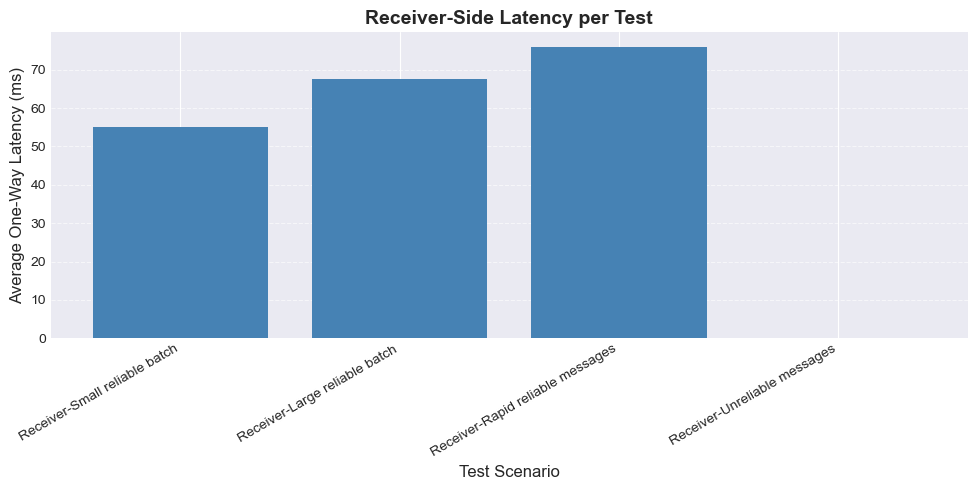

In [153]:
if not df_recv.empty:
    plt.figure(figsize=(10, 5))
    colors = df_recv["channel"].map({"Reliable": "steelblue", "Unreliable": "orange"})
    plt.bar(df_recv["label"], df_recv["latency_ms"], color=colors)
    plt.ylabel("Average One-Way Latency (ms)", fontsize=12)
    plt.xlabel("Test Scenario", fontsize=12)
    plt.title("Receiver-Side Latency per Test", fontsize=14, fontweight='bold')
    plt.xticks(rotation=30, ha="right")
    plt.grid(axis="y", linestyle="--", alpha=0.6)
    plt.tight_layout()
    
    out = os.path.join(FIGURES_DIR, "latency_ms.png")
    plt.savefig(out, dpi=300, bbox_inches='tight')
    print(f"✓ Saved: {out}")
    plt.show()
else:
    print("⚠️  No receiver data available for latency plot")

## 9. Plot: Jitter

Show the jitter (variation in latency) measured at the receiver.

✓ Saved: figures/jitter_ms.png


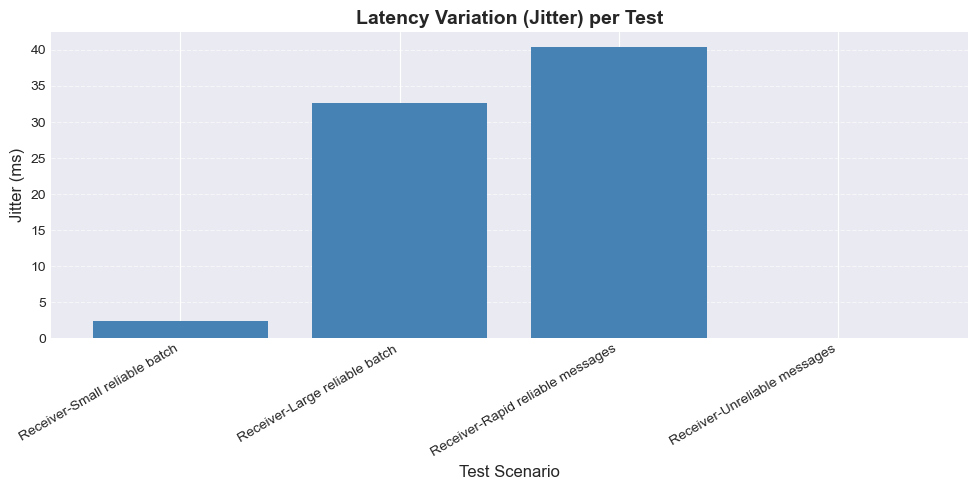

In [154]:
if not df_recv.empty:
    plt.figure(figsize=(10, 5))
    colors = df_recv["channel"].map({"Reliable": "steelblue", "Unreliable": "orange"})
    plt.bar(df_recv["label"], df_recv["jitter_ms"], color=colors)
    plt.ylabel("Jitter (ms)", fontsize=12)
    plt.xlabel("Test Scenario", fontsize=12)
    plt.title("Latency Variation (Jitter) per Test", fontsize=14, fontweight='bold')
    plt.xticks(rotation=30, ha="right")
    plt.grid(axis="y", linestyle="--", alpha=0.6)
    plt.tight_layout()
    
    out = os.path.join(FIGURES_DIR, "jitter_ms.png")
    plt.savefig(out, dpi=300, bbox_inches='tight')
    print(f"✓ Saved: {out}")
    plt.show()
else:
    print("⚠️  No receiver data available for jitter plot")

## 10. Plot: Packet Delivery Ratio (PDR)

Display the packet delivery ratio as a percentage to show reliability.

✓ Saved: figures/pdr_pct.png


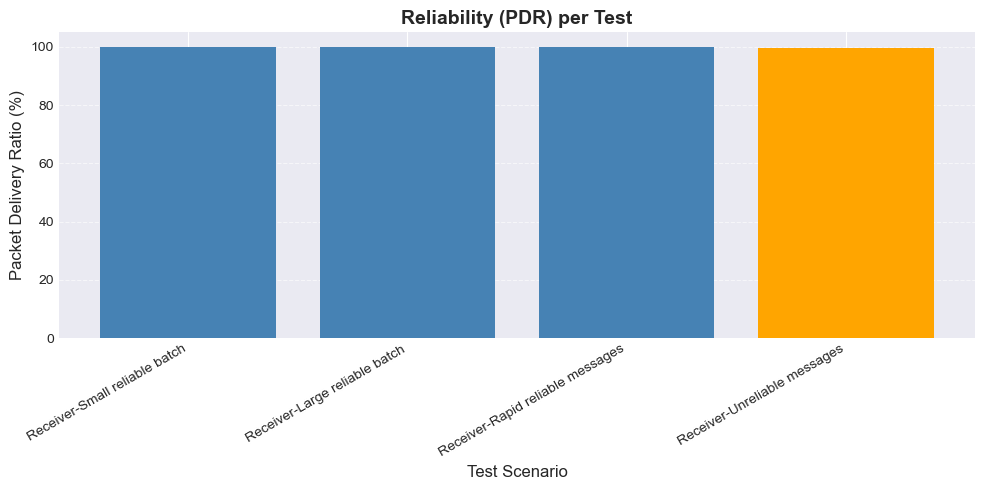

In [155]:
if not df_recv.empty:
    plt.figure(figsize=(10, 5))
    colors = df_recv["channel"].map({"Reliable": "steelblue", "Unreliable": "orange"})
    plt.bar(df_recv["label"], df_recv["pdr_pct"], color=colors)
    plt.ylabel("Packet Delivery Ratio (%)", fontsize=12)
    plt.xlabel("Test Scenario", fontsize=12)
    plt.title("Reliability (PDR) per Test", fontsize=14, fontweight='bold')
    plt.ylim([0, 105])  # Set range to 0-105% for better visualization
    plt.xticks(rotation=30, ha="right")
    plt.grid(axis="y", linestyle="--", alpha=0.6)
    plt.tight_layout()
    
    out = os.path.join(FIGURES_DIR, "pdr_pct.png")
    plt.savefig(out, dpi=300, bbox_inches='tight')
    print(f"✓ Saved: {out}")
    plt.show()
else:
    print("⚠️  No receiver data available for PDR plot")

## 11. Plot: Receiver Throughput

Show the receive throughput measured at the receiver side.

✓ Saved: figures/throughput_bps_recv.png


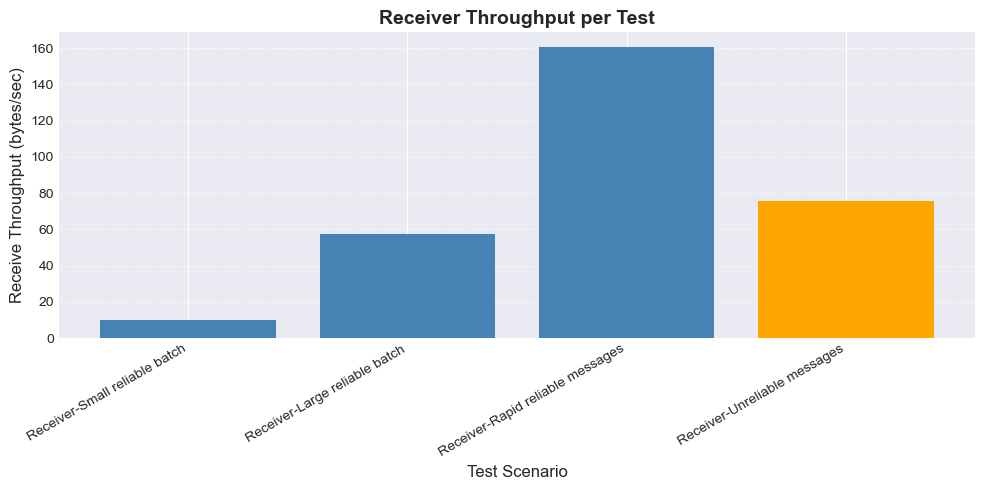

In [156]:
if not df_recv.empty:
    plt.figure(figsize=(10, 5))
    colors = df_recv["channel"].map({"Reliable": "steelblue", "Unreliable": "orange"})
    plt.bar(df_recv["label"], df_recv["throughput_bps_recv"], color=colors)
    plt.ylabel("Receive Throughput (bytes/sec)", fontsize=12)
    plt.xlabel("Test Scenario", fontsize=12)
    plt.title("Receiver Throughput per Test", fontsize=14, fontweight='bold')
    plt.xticks(rotation=30, ha="right")
    plt.grid(axis="y", linestyle="--", alpha=0.6)
    plt.tight_layout()
    
    out = os.path.join(FIGURES_DIR, "throughput_bps_recv.png")
    plt.savefig(out, dpi=300, bbox_inches='tight')
    print(f"✓ Saved: {out}")
    plt.show()
else:
    print("⚠️  No receiver data available for throughput plot")

## 12. Export Summary Statistics to CSV

Save the sender and receiver summary data to CSV files for further analysis or reporting.

In [157]:
if not df_sender.empty:
    sender_csv = os.path.join(FIGURES_DIR, "sender_summary.csv")
    df_sender.to_csv(sender_csv, index=False)
    print(f"✓ Exported sender summary to: {sender_csv}")

if not df_recv.empty:
    receiver_csv = os.path.join(FIGURES_DIR, "receiver_summary.csv")
    df_recv.to_csv(receiver_csv, index=False)
    print(f"✓ Exported receiver summary to: {receiver_csv}")

print(f"\n{'='*60}")
print("All metrics exported and visualized successfully!")
print(f"{'='*60}")

✓ Exported sender summary to: figures/sender_summary.csv
✓ Exported receiver summary to: figures/receiver_summary.csv

All metrics exported and visualized successfully!
